In [36]:
'''
code copied directly from https://www.dgl.ai/blog/2019/02/17/gat.html 
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
    
    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e' : F.leaky_relu(a)}
    
    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z' : edges.src['z'], 'e' : edges.data['e']}
    
    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h' : h}
    
    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge
    
    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        #   multiple head outputs are concatenated together. Also, only
        #   one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)
    
    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [37]:
class STAN(nn.Module):
    def __init__(self, g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device):
        super(STAN, self).__init__()
        self.g = g
        
        self.layer1 = MultiHeadGATLayer(self.g, in_dim, hidden_dim1, num_heads)
        self.layer2 = MultiHeadGATLayer(self.g, hidden_dim1 * num_heads, hidden_dim2, 1)

        self.pred_window = pred_window
        self.gru = nn.GRUCell(hidden_dim2, gru_dim)
    
        self.nn_pred = nn.Linear(gru_dim, pred_window)

        self.hidden_dim2 = hidden_dim2
        self.gru_dim = gru_dim
        self.device = device

    def forward(self, dynamic, h=None):
        num_loc, timestep, n_feat = dynamic.size()

        if h is None:
            h = torch.zeros(1, self.gru_dim).to(self.device)
            gain = nn.init.calculate_gain('relu')
            nn.init.xavier_normal_(h, gain=gain)  

        new_pred = []

        for each_step in range(timestep):        
            cur_h = self.layer1(dynamic[:, each_step, :])
            cur_h = F.elu(cur_h)
            cur_h = self.layer2(cur_h)
            cur_h = F.elu(cur_h)
            
            cur_h = torch.max(cur_h, 0)[0].reshape(1, self.hidden_dim2)
            
            h = self.gru(cur_h, h)
            
            pred_cases = self.nn_pred(h)

            new_pred.append(pred_cases)

        new_pred = torch.stack(new_pred).to(self.device).permute(1,0,2)

        return new_pred, h

In [38]:
import utils 
import numpy as np
datafile = 'preprocessed_data.csv'

window_size = 2 # train on previous 2 years
train_weeks = window_size * 52
pred_weeks = 52 # predict 1 year
start = 2010
end = 2019
end_train = end - (window_size)*2
start_test = end_train + window_size
end_test = start_test

# get_data() returns ordered first by week, then by location within each week
train_X, train_y, X_mean, X_std, y_mean, y_std, loc_list = utils.get_data(start, end_train, datafile)
test_X, test_y, _, _, _, _, _ = utils.get_data(start_test, end_test, datafile)
print(test_y.astype(int))

train_X = ( train_X - X_mean ) / X_std
test_X = ( test_X - X_mean ) / X_std

train_y = ( train_y - y_mean ) / y_std 
test_y = ( test_y - y_mean ) / y_std

num_locs = len(loc_list)


[[  232   279   321   495   725  1386  2004  3292  3603  4650  6935 11898
  16568 14643 13457 15126 17631 20940 20960 19897 17932 15615 13974 11397
   5268   997   299   112    82    25    23    20    15    14     5    21
     12    18    14    11    11    16     6     8    10     5    13    10
     11     8    29    16]]


In [39]:
# we need to re-format our data shape so that it is by location, timestep, features
# e.g., 54 locations, timesteps determined by get_data (e.g., 6), window*52 features
def reshape_data(X):
    spatial_X = []
    for time in X:
        t = []
        for week in range(train_weeks):
            w = []
            for location in range(num_locs):
                w.append(time[week*num_locs + location])
            w = np.array(w)
            t.append(w)
        t = np.array(t)
        spatial_X.append(t)
    spatial_X = np.array(spatial_X)
    new_X = spatial_X.transpose(2, 0, 1)
    print(new_X.shape)
    return new_X

train_X = reshape_data(train_X)
test_X = reshape_data(test_X)

(54, 6, 104)
(54, 1, 104)


In [40]:
import dgl
edges = utils.get_edges(train_X, loc_list)
g = dgl.graph(edges)
print(g.number_of_nodes)

<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=54, num_edges=2916,
      ndata_schemes={}
      edata_schemes={})>


In [41]:
in_dim = train_weeks
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_weeks, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=104, out_features=32, bias=False)
        (attn_fc): Linear(in_features=64, out_features=1, bias=False)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=False)
        (attn_fc): Linear(in_features=64, out_features=1, bias=False)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_pred): Linear(in_features=32, out_features=52, bias=True)
)

In [42]:
train_X = torch.tensor(train_X).to(device)
train_y = torch.tensor(train_y).to(device)

test_X = torch.tensor(test_X).to(device)
test_y = torch.tensor(test_y).to(device)

print(train_X.size())

torch.Size([54, 6, 104])


In [43]:
#Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

for epoch in range(400):
    model.train()
    optimizer.zero_grad()
    
    pred_cases,  _ = model(train_X)
    loss = criterion(pred_cases.squeeze(), train_y)
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
   
    if loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = loss
        #print('-----Save best model-----')
    if epoch % 10 == 0:
        print('Epoch %d, Loss %.8f'%(epoch, all_loss[-1]))

Epoch 0, Loss 1.00990927
Epoch 10, Loss 0.27253595
Epoch 20, Loss 0.13204364
Epoch 30, Loss 0.03586797
Epoch 40, Loss 0.02507568
Epoch 50, Loss 0.01611703
Epoch 60, Loss 0.00990489
Epoch 70, Loss 0.00412309
Epoch 80, Loss 0.00306113
Epoch 90, Loss 0.00401771
Epoch 100, Loss 0.00209575
Epoch 110, Loss 0.00222013
Epoch 120, Loss 0.00113689
Epoch 130, Loss 0.00251751
Epoch 140, Loss 0.00670313
Epoch 150, Loss 0.00123781
Epoch 160, Loss 0.00112182
Epoch 170, Loss 0.00102572
Epoch 180, Loss 0.00088865
Epoch 190, Loss 0.00070883
Epoch 200, Loss 0.00062644
Epoch 210, Loss 0.00047517
Epoch 220, Loss 0.00048415
Epoch 230, Loss 0.00034148
Epoch 240, Loss 0.00053130
Epoch 250, Loss 0.00054764
Epoch 260, Loss 0.00036793
Epoch 270, Loss 0.00028602
Epoch 280, Loss 0.00025554
Epoch 290, Loss 0.00019381
Epoch 300, Loss 0.00021063
Epoch 310, Loss 0.00013622
Epoch 320, Loss 0.00013052
Epoch 330, Loss 0.00013501
Epoch 340, Loss 0.00010239
Epoch 350, Loss 0.00010750
Epoch 360, Loss 0.00015909
Epoch 370, L

In [44]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

prev_pred, h = model(train_X)
pred_y, _ = model(test_X, h=h)

pred_y = pred_y.detach().cpu().numpy()[0] # only one timestep 
test_y = test_y.detach().cpu().numpy()

MSE: 11968507.0


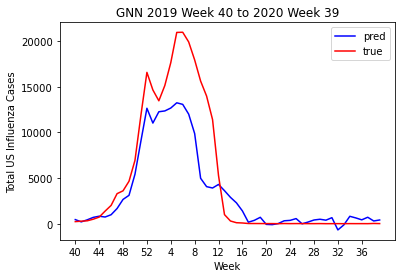

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

pred_y = pred_y * y_std + y_mean # de-norm
test_y = test_y * y_std + y_mean

weeks = [i for i in range(52)]
print(f"MSE: {mean_squared_error(pred_y, test_y)}")
# compare test_y and pred_y
plt.plot(weeks, pred_y[0], label="pred", color="blue")
plt.plot(weeks, test_y[0], label="true", color="red")
plt.title(f"GNN {end} Week 40 to {end+1} Week 39")
plt.xlabel("Week")
plt.ylabel("Total US Influenza Cases")
plt.legend()

week_labels = [i%52 + 1 for i in range(39, 52+39, 4)]
_, _ = plt.xticks(weeks[::4], week_labels)

import pickle
pickle.dump(pred_y[0], open("results/GNN_2019_pred_list", "wb"), 2)

(54, 1, 104)


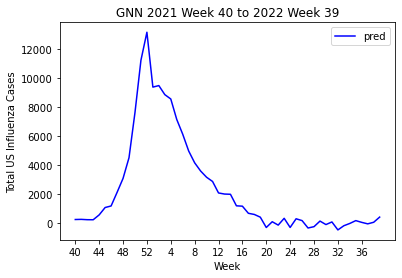

In [48]:
end = 2021
test_X, test_y, _, _, _, _, _ = utils.get_data(2019, 2019, datafile)
test_X = ( test_X - X_mean ) / X_std

test_X = reshape_data(test_X)

test_X = torch.tensor(test_X).to(device)

pred_y, _ = model(test_X, h=h)
pred_y = pred_y.detach().cpu().numpy()[0]
pred_y = pred_y * y_std + y_mean # de-norm
#test_y = test_y * y_std + y_mean

weeks = [i for i in range(52)]
#print(f"MSE: {mean_squared_error(pred_y, test_y)}")
# compare test_y and pred_y
plt.plot(weeks, pred_y[0], label="pred", color="blue")
#plt.plot(weeks, test_y[0], label="true", color="red")
plt.title(f"GNN {end} Week 40 to {end+1} Week 39")
plt.xlabel("Week")
plt.ylabel("Total US Influenza Cases")
plt.legend()

week_labels = [i%52 + 1 for i in range(39, 52+39, 4)]
_, _ = plt.xticks(weeks[::4], week_labels)

import pickle
pickle.dump(pred_y[0], open("results/GNN_2021_pred_list", "wb"), 2)